In [1]:
import numpy as np
from scipy.linalg import expm
from numpy.linalg import matrix_power
from scipy import signal
import matplotlib.pyplot as plt
import cvxpy as cp
import scipy.io
import pandas as pd

# Thruster lumped-mass model
![*Lumped Mass Model*](lumped_thruster.png)

IceExcitation (20001, 1)
IceLoad1 (20001, 1)
IceLoad2 (20001, 1)
IceLoad3 (20001, 1)
SpeedCoupling (20001, 1)
TorqueCoupling (20001, 1)
TorqueExcitation (20001, 1)
TorquePropeller (20001, 1)
TorqueThrust (20001, 1)
time (20001, 1)


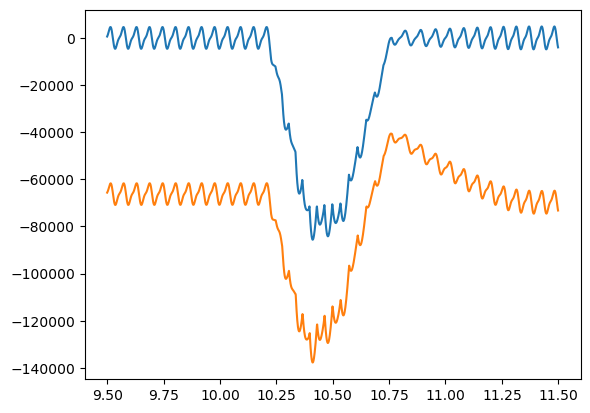

In [12]:
## 
Fs = 1000
t_start = 9.5
t_stop = 11.5
k_start = int(Fs*t_start)
k_stop = int(Fs*t_stop)

### Load data and convert it from .mat to pd df ##
data = scipy.io.loadmat('data/data_IFAC_CAMS19.mat')
df = pd.DataFrame()
for var_name in data:
    if not var_name.startswith('__'):
        array_data = data[var_name]
        print(var_name, np.shape(array_data))
        df[var_name] = pd.DataFrame(array_data)

time = np.array(df['time'])
y = np.array([df['SpeedCoupling']]) # [angular_velocity_coupling, torque_coupling]
u = np.array([df['TorqueExcitation'], df['TorquePropeller']]) # [propeller_torque, motor_torque]

u_motor = np.array([df['TorqueExcitation']])
u_propeller = np.array([df['TorquePropeller']])



### Load model and convnert it from .mat to dict ###
dlti_mat = scipy.io.loadmat('data/dlti_IFAC_CAMS19.mat')
dlti = {key: value for key, value in dlti_mat.items() if not key.startswith('__')}

A = np.array(dlti['A'])
B = np.array(dlti['B'])
B_motor = B[:,0].reshape(-1,1)
B_propeller = B[:,1].reshape(-1,1)

C = np.array(dlti['C'])
D = np.array(dlti['D'])


time = time[k_start:k_stop]
y = y[:,k_start:k_stop]
u = u[:, k_start:k_stop]
u_motor = u_motor[:,k_start:k_stop]
u_propeller = u_propeller[:,k_start:k_stop]

plt.plot( time, u.T )



### Moving-horizong input and state estimation

\begin{align*}
    &\underset{ x, u  }{\mathrm{minimize}} \quad \sum_{n=k-N}^{k} v_n^T Q_v^{-1} v_n + \sum_{n=k-N}^{k} w_n^T Q_w^{-1} w_n + \sum_{n=k-N-1}^{k-1} v_{\mathrm{u},k}^T Q_u^{-1} v_{\mathrm{u},k} \\
    &\text{subject to} \\
    &x_{n} = Ax_{n-1} + Bu_{n-1} + w_n, &n&=k-N,...,k \\
    &y_n = Cx_n + v_n, &n&=k-N,...,k \\
    &u_n = u_{n-1} + v_{\mathrm{u},k}, &n&=k-N,...,k \\
\end{align*}


In [32]:
HORIZON_LENGTH = 1
DATA_LENGTH = np.max(np.shape(y))
print(DATA_LENGTH)

n_states = np.shape(A)[0]
n_known_inputs = 1
n_unknown_inputs = 1
n_outputs = np.shape(C)[0]

print(n_outputs)

# covariance matrices
Q_v = 0.01*np.eye(n_outputs)
Q_w = 0.1*np.eye(n_states)
Q_u = 1E5*np.eye(n_unknown_inputs)

# compute inverces
Q_v_inv = np.linalg.inv(Q_v)
Q_w_inv = np.linalg.inv(Q_w)
Q_u_inv = np.linalg.inv(Q_u)

def cvx_MHE_SISE(y, u_known, xhat, uhat, Q_v_inv, Q_w_inv, Q_u_inv, HORIZON_LENGTH):
    '''Simultaneous input and state estimation (SISE) formualtion as a convex optimization problem where
    HORIZON_LENGTH: The length of the moving horizon
    y: The mesuremente vector y_{k-N},...,y_k
    xhat: Is the state estimate from previous iteration \hat{x}_{k-N-1|k-N-1}
    Q_v, Q_w: Are the measurement error and state prediction error covariance matrices.

    '''
    # define optimization variables
    x_var = cp.Variable((n_states,HORIZON_LENGTH), complex=False)
    u_var = cp.Variable((n_unknown_inputs,HORIZON_LENGTH), complex=False)
    v_u_var = cp.Variable((n_unknown_inputs,HORIZON_LENGTH), complex=False)

    # define objective function
    obj = 0
    for k in range(HORIZON_LENGTH):
        if k == 0:
            obj += cp.quad_form( y[:,k] - C@x_var[:,k], Q_v_inv ) + cp.quad_form( A@xhat + B_motor@u_known[:,k] + B_propeller@u_var[:,k] - x_var[:,k], Q_w_inv ) + cp.quad_form( v_u_var[:,k], Q_u_inv ) 
        else:
            obj += cp.quad_form( y[:,k] - C@x_var[:,k], Q_v_inv ) + cp.quad_form( A@x_var[:,k-1]+ B_motor@u_known[:,k] + B_propeller@u_var[:,k] - x_var[:,k], Q_w_inv ) + cp.quad_form( v_u_var[:,k], Q_u_inv )

    objective = cp.Minimize( obj )

    # define constraints
    constraints = []
    for k in range(HORIZON_LENGTH):
        if k == 0:
            constraints.append( u_var[:,k] == uhat + v_u_var[:,k] )
        else:
            constraints.append( u_var[:,k] == u_var[:,k-1] + v_u_var[:,k] )

    # define problem
    prob = cp.Problem(objective, constraints)

    # solve optimizaiton problem
    prob.solve()
    return x_var.value, u_var.value


2000
1


In [33]:
#

xhat = np.zeros( (n_states,DATA_LENGTH) )
uhat = np.zeros( (n_unknown_inputs,DATA_LENGTH) )
for i in range( DATA_LENGTH - HORIZON_LENGTH + 1):
    print(i)
    #sliding horizon
    y_horizon = y[:,i:i+HORIZON_LENGTH]
    u_motor_horizon = u_motor[:,i:i+HORIZON_LENGTH]

    if i == 0:
        # first iteration use x0 as initial state estimate
        xhat_horizon, uhat_horizon = cvx_MHE_SISE(y_horizon, u_motor_horizon, xhat[:,i], uhat[:,i], Q_v_inv, Q_w_inv, Q_u_inv, HORIZON_LENGTH)
    else:
        xhat_horizon, uhat_horizon = cvx_MHE_SISE(y_horizon, u_motor_horizon, xhat[:,i-1], uhat[:,i-1], Q_v_inv, Q_w_inv, Q_u_inv, HORIZON_LENGTH)

    if i == DATA_LENGTH - HORIZON_LENGTH:
        #append the last horizon
        xhat[:,-HORIZON_LENGTH:] = xhat_horizon
        uhat[:,-HORIZON_LENGTH:] = uhat_horizon
    else:
        xhat[:,i] = xhat_horizon[:,0]
        uhat[:,i] = uhat_horizon[:,0]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

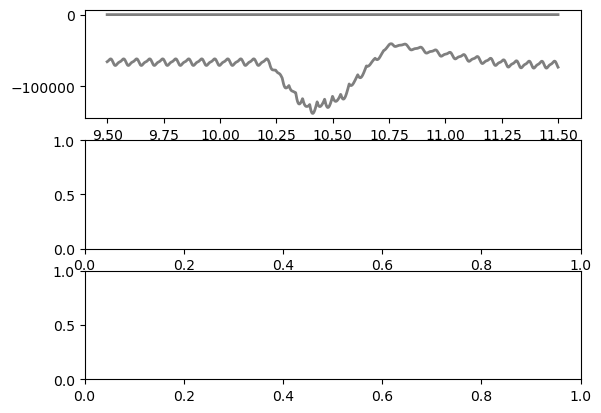

In [34]:

# plot result
fig, axs = plt.subplots(3)
axs[0].plot(time.T, u_propeller.T, 'k', alpha=0.5, linewidth=2, label='true input')
axs[0].plot(time.T, uhat.T, 'k', alpha=0.5, linewidth=2, label='true input')


In [ ]:

axs[0].plot(t, u0,'k', alpha=0.5, linewidth=2, label='true input')
axs[0].scatter(t, uhat, alpha=0.25, color='r', edgecolor=None, label='estimated input')
axs[0].set_ylabel('Force (N)')
axs[0].legend()
axs[1].plot(tout, xout[:,1], color='k', alpha=0.5, label='true velocity')
axs[1].scatter(tout, y, alpha=0.25, color='k', edgecolor=None, label='measured velocity')
axs[1].scatter(t, xhat[1,:], alpha=0.25, color='r', edgecolor=None, label='estimated velocity')
axs[1].set_ylabel('Velocity (m/s)')
axs[1].legend()
axs[2].plot(tout, xout[:,0], color='k', alpha=0.25, label='true position')
axs[2].scatter(t, xhat[0,:], alpha=0.25, color='r', edgecolor=None, label='estimated position')
axs[2].set_ylabel('Position (m)')
axs[2].legend()